# Section4 Project
### AI 02 박상지
---

## **Project Description**

* 데이터 
  * 비소세포폐암 환자와 정상 환자의 가슴 CT 촬영 이미지
  * 비소세포폐암 : 폐암의 큰 종류 중 하나. 폐암의 대부분을 차지하고 있다.

<br>

* 데이터 구조 : train, validation, test 데이터가 각각 **4개**의 클래스를 가지고 있음

* 클래스
  * **normal** : 정상 
  
   <img src='https://drive.google.com/uc?id=1AdU6HiIwdgfVjwNmtCHecQb7fahVTeAG' width="200"/>
  * **adenocarcinoma of lung(폐선암)** : 폐 말초 부위에서 잘 생기고 여성이나 담배를 피우지 않는 사람도 걸리며, 최근 들어 **발생 빈도가 늘고 있다.**

   <img src='https://drive.google.com/uc?id=11sNRJ2dOPzILlmD7ExtSM9fJbRqhU0_g' width="200"/>
  * **squamous cell carcinoma of lung(편평상피암)** : 주로 폐 중심부에서 발견되며, 남성에게 많이 나타나고 흡연과 관련이 많다. 예후가 좋지 않은 암으로 알려져 있다.

   <img src='https://drive.google.com/uc?id=1-3IH-tWtOP2hUGCfL4x8QJiFRi9ZPlIO' width="200"/>
  * **large cell carcinoma(대세포 폐암)** : 폐 표면 근처에서 주로 발생하며 암세포가 매우 크고 그 일부는 **빠르게 전이**하는 경향이 있어서 다른 비소세포폐암들보다 예후가 나쁜 편이다.

   <img src='https://drive.google.com/uc?id=107ZTakRkG75Dr6xmWieOYhRZK5HAvWlt' width="200"/>
<br>

* 모델 목적
  * 폐암 환자 중에서도 특히 폐암의 대부분을 차지하고 있는 **비소세포폐암** 환자들의 구체적인 병명(폐암의 종류) 확진하고 **최대한 빠른 치료와 조치**를 위함.
  * 특히, **빠르게 전이하는** 대세포 폐암 환자를 찾아내어 치료를 신속히 진행할 수 있는 것에 큰 의미가 있음

<br>

* 분석 모델 : **CNN(Convolutional Neural Network)**
  * 본 분석에서는 이미지 데이터를 사용하기 때문에 이미지 공간의 유실을 최소화 할 수 있으며 특징 추출 및 학습이 효율적인 CNN 모델 사용
  * 각 레이어의 입출력 데이터 형상을 유지하며 인접 이미지와의 특징을 효과적으로 인식
  * 추출한 이미지의 특징을 모으고 강화하는 Pooling layer
  * 필터 공유로 인하여 일반 인공 신경망보다 학습 파라미터가 적기 때문에 효율적인 분석 진행 가능

#### 데이터 불러오기

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#@title
import numpy as np
import random
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#### 시드 고정

In [27]:
#@title
# 시드 고정
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 30
    batch_size = 32
    epochs_kf = 10

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed

seed_everything(config.seed)

#### **ImageDataGenerator를 사용하여 데이터 전처리 및 증강**

In [11]:
# Training Data
TRAINING_DIR = "/content/drive/MyDrive/Study/LungCancer/train"
training_datagen = ImageDataGenerator(rescale = 1./255, # 이미지 크기 조정 (정규화)
                                   validation_split = 0.2,  
                                   rotation_range=5, # 0도와 5도 사이의 랜덤한 각도로 회전
                                   width_shift_range=0.2, # 수평으로 랜덤 이동
                                   height_shift_range=0.2, # 수직으로 랜덤 이동
                                   shear_range=0.2, # 시계 반대 방향으로 변형
                                   zoom_range=0.2, # 확대/축소
                                   horizontal_flip=True, # 수평으로 뒤집기
                                   fill_mode='nearest') # 생성되는 빈 공간을 가장 가까운 색으로 채우기

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224,224),
    class_mode='categorical', # 다중 클래스
    batch_size = 64
)

# Validation Data
VALIDATION_DIR = "/content/drive/MyDrive/Study/LungCancer/valid"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224,224),
    class_mode='categorical',
    batch_size= 64
)

# Test Data
TEST_DIR = "/content/drive/MyDrive/Study/LungCancer/test"
test_datagen  = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    class_mode='categorical',
    batch_size= 64
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#### **모델 생성**

* 4개의 은닉층
  - Convolution layer, Maxpooling layer
  - 활성화 함수 : relu

* 출력층
  - 활성화 함수 : softmax

* Compile
  - loss 함수 : categorical_crossentropy
  - optimizer : Adam

In [21]:
from tensorflow.keras.optimizers import Adam
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=config.lr),
    metrics=['acc'])

#### **모델 학습**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = config.epochs, #30
    batch_size = config.batch_size,#32
    verbose = 1,
    callbacks=EarlyStopping(monitor='val_loss', verbose=1, patience=5)
)

Epoch 1/30
10/10 [==============================] - 42s 4s/step - loss: 4.5360 - acc: 0.2512 - val_loss: 1.3968 - val_acc: 0.1806
Epoch 2/30
10/10 [==============================] - 40s 4s/step - loss: 1.3361 - acc: 0.2871 - val_loss: 1.4325 - val_acc: 0.1806
Epoch 3/30
10/10 [==============================] - 40s 4s/step - loss: 1.2887 - acc: 0.3507 - val_loss: 1.3339 - val_acc: 0.2500
Epoch 4/30
10/10 [==============================] - 40s 4s/step - loss: 1.1673 - acc: 0.4633 - val_loss: 1.2430 - val_acc: 0.4722
Epoch 5/30
10/10 [==============================] - 39s 4s/step - loss: 1.0751 - acc: 0.5351 - val_loss: 1.1334 - val_acc: 0.4861
Epoch 6/30
10/10 [==============================] - 39s 4s/step - loss: 1.0413 - acc: 0.5090 - val_loss: 1.1106 - val_acc: 0.4861
Epoch 7/30
10/10 [==============================] - 40s 4s/step - loss: 1.0697 - acc: 0.5171 - val_loss: 1.3208 - val_acc: 0.3472
Epoch 8/30
10/10 [==============================] - 40s 4s/step - loss: 1.0214 - acc: 0.54

In [24]:
model.evaluate(test_generator, verbose=1) #metrics 변경해보기

5/5 [==============================] - 95s 23s/step - loss: 1.7946 - acc: 0.4159


[1.794556975364685, 0.4158730208873749]

---
* 검증데이터 정확도 : 68.06%
* 테스트 데이터 정확도 : 41.59%
---

#### **교차검증 : K-fold (5-fold)**

In [26]:
#@title
# Lad Whole Data
DATA_DIR = "/content/drive/MyDrive/Study/LungCancer"
df_datagen  = ImageDataGenerator(rescale = 1./255)
df_generator = df_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224,224),
    class_mode='categorical',
    batch_size= 64
)

Found 1000 images belonging to 3 classes.


In [34]:
#@title
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True)

for trian, test in kf.split(df_generator) :
  TRAINING_DIR = "/content/drive/MyDrive/Study/LungCancer/train"
  training_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,  
                                   rotation_range=5, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

  # Validation Data
  VALIDATION_DIR = "/content/drive/MyDrive/Study/LungCancer/valid"
  validation_datagen = ImageDataGenerator(rescale = 1./255)
  train_generator = training_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size=(224,224),
      class_mode='categorical', # 다중 클래스
      batch_size = 64
  )
  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size=(224,224),
      class_mode='categorical',
      batch_size= 64
  )

  # Test Data
  TEST_DIR = "/content/drive/MyDrive/Study/LungCancer/test"
  test_datagen  = ImageDataGenerator(rescale = 1./255)
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR,
      target_size=(224,224),
      class_mode='categorical',
      batch_size= 64
  ) 
    
  model_kf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ])

  model.compile(loss='categorical_crossentropy',
       optimizer= Adam(learning_rate=config.lr),
       metrics=['acc'])
  
  model.fit(train_generator,
    validation_data = validation_generator,
    epochs = config.epochs_kf,
    batch_size = config.batch_size,
    verbose = 1,
    callbacks=EarlyStopping(monitor='val_loss', verbose=1, patience=5))

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Epoch 1/10
10/10 [==============================] - 42s 4s/step - loss: 0.7650 - acc: 0.6721 - val_loss: 0.8462 - val_acc: 0.6944
Epoch 2/10
10/10 [==============================] - 40s 4s/step - loss: 0.7028 - acc: 0.6900 - val_loss: 0.7694 - val_acc: 0.6667
Epoch 3/10
10/10 [==============================] - 40s 4s/step - loss: 0.6193 - acc: 0.7292 - val_loss: 0.7840 - val_acc: 0.6806
Epoch 4/10
10/10 [==============================] - 40s 4s/step - loss: 0.6251 - acc: 0.7031 - val_loss: 0.7653 - val_acc: 0.6806
Epoch 5/10
10/10 [==============================] - 40s 4s/step - loss: 0.6473 - acc: 0.7129 - val_loss: 0.8810 - val_acc: 0.5694
Epoch 6/10
10/10 [==============================] - 40s 4s/step - loss: 0.6008 - acc: 0.7308 - val_loss: 0.7539 - val_acc: 0.7083
Epoch 7/10
10/10 [==============================] - 40s 4s/step - loss: 0.6325 - acc: 0.7129 - val

In [35]:
# Accuracy after doing Cross Validation(5-fold)

model.evaluate(test_generator, verbose=1)

5/5 [==============================] - 6s 1s/step - loss: 1.4532 - acc: 0.5556


[1.453237533569336, 0.5555555820465088]


---

검증 데이터 정확도 : 59.72%

테스트 데이터 정확도 : 55.56% (약 14% 증가)

---



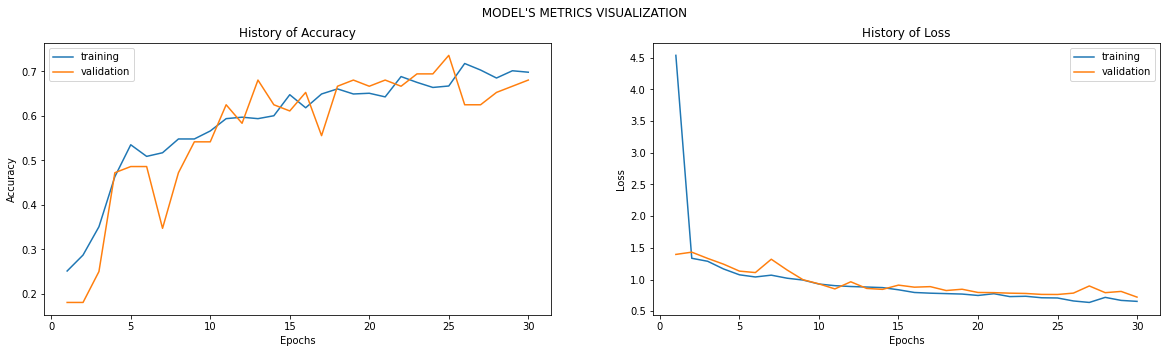

In [37]:
#@title
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['acc'],history.history['val_acc'],
               history.history['loss'],history.history['val_loss'],
              )

---

모델이 학습되면서 오차가 줄어드는 동시에 정확도가 점점 증가하는 것을 볼 수 있다

---

## 결과

* CrossValidation(5-fold)를 통해서 최종적으로 55.56%의 정확도를 보이는 대소세포폐암 분류 모델을 생성하였다.
* 정확도를 크게 높이지는 못했지만 추후 여러 보정을 통하여 더욱 최적화할 수 있는 가능성이 있다.
* 모델 활용 방안
 * 폐암 환자인지 확인
 * 그리고 폐암 중에서도 정확이 어떤 종류의 폐암을 가지고 있는지 확인
 * 암 종류에 따른 정확하고 빠른 치료를 시행